# Zero-Shot Image Classification with CLIP & Florence-2 Tasks

This notebook demonstrates:
1. Zero-shot image classification with CLIP
2. Florence-2 for VQA, grounding, and captioning

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from typing import List

# Only needed on the Udacity workspace. Comment this out if running on another system.
import os
os.environ['HF_HOME'] = '/voc/data/huggingface'
os.environ['OLLAMA_MODELS'] = '/voc/data/ollama/cache'
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ['PATH'] = f"/voc/data/ollama/bin:/voc/data/ffmpeg/bin:{os.environ.get('PATH', '')}"
os.environ['LD_LIBRARY_PATH'] = f"/voc/data/ollama/lib:/voc/data/ffmpeg/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"


def display_grid(images: List[Image.Image], *args, **kwargs):
    """
    Wrap the make_grid function from torchvision accepting PIL.Image instances
    instead of tensors. Every other arguments or keyword arguments is passed
    to make_grid.

    Images are going to be resized and center-cropped to 256x256 to fit
    in the grid.
    """
    transform = T.Compose(
        [
            T.Resize(256),  # resize shorter side to 256
            T.CenterCrop(256),  # center crop to 256x256 square
            T.ToTensor(),
        ]
    )

    tensors = [transform(img) for img in images]
    grid = torchvision.utils.make_grid(tensors, *args, **kwargs)
    _, sub = plt.subplots(dpi=300)
    sub.imshow(grid.permute(1, 2, 0))
    sub.axis("off")
    plt.show()


def display_clip_results(
    images: List[Image.Image], probs: torch.Tensor, classes: List[str]
):

    fig, subs = plt.subplots(3, 4, figsize=(16, 12))
    axes = subs.flatten()

    for i, (img, prob) in enumerate(zip(images, probs)):
        # Show image
        axes[i].imshow(img)
        axes[i].axis("off")

        # Get top 2 predictions
        top2_indices = prob.argsort(descending=True)[:2]
        top1_label = classes[top2_indices[0]]
        top1_prob = prob[top2_indices[0]].item()
        top2_label = classes[top2_indices[1]]
        top2_prob = prob[top2_indices[1]].item()

        # Set title with top 2 predictions
        axes[i].set_title(
            f"{top1_label} ({top1_prob:.2%})\n{top2_label} ({top2_prob:.2%})",
            fontsize=14,
        )

    plt.tight_layout()
    plt.show()

## Load Sample Images

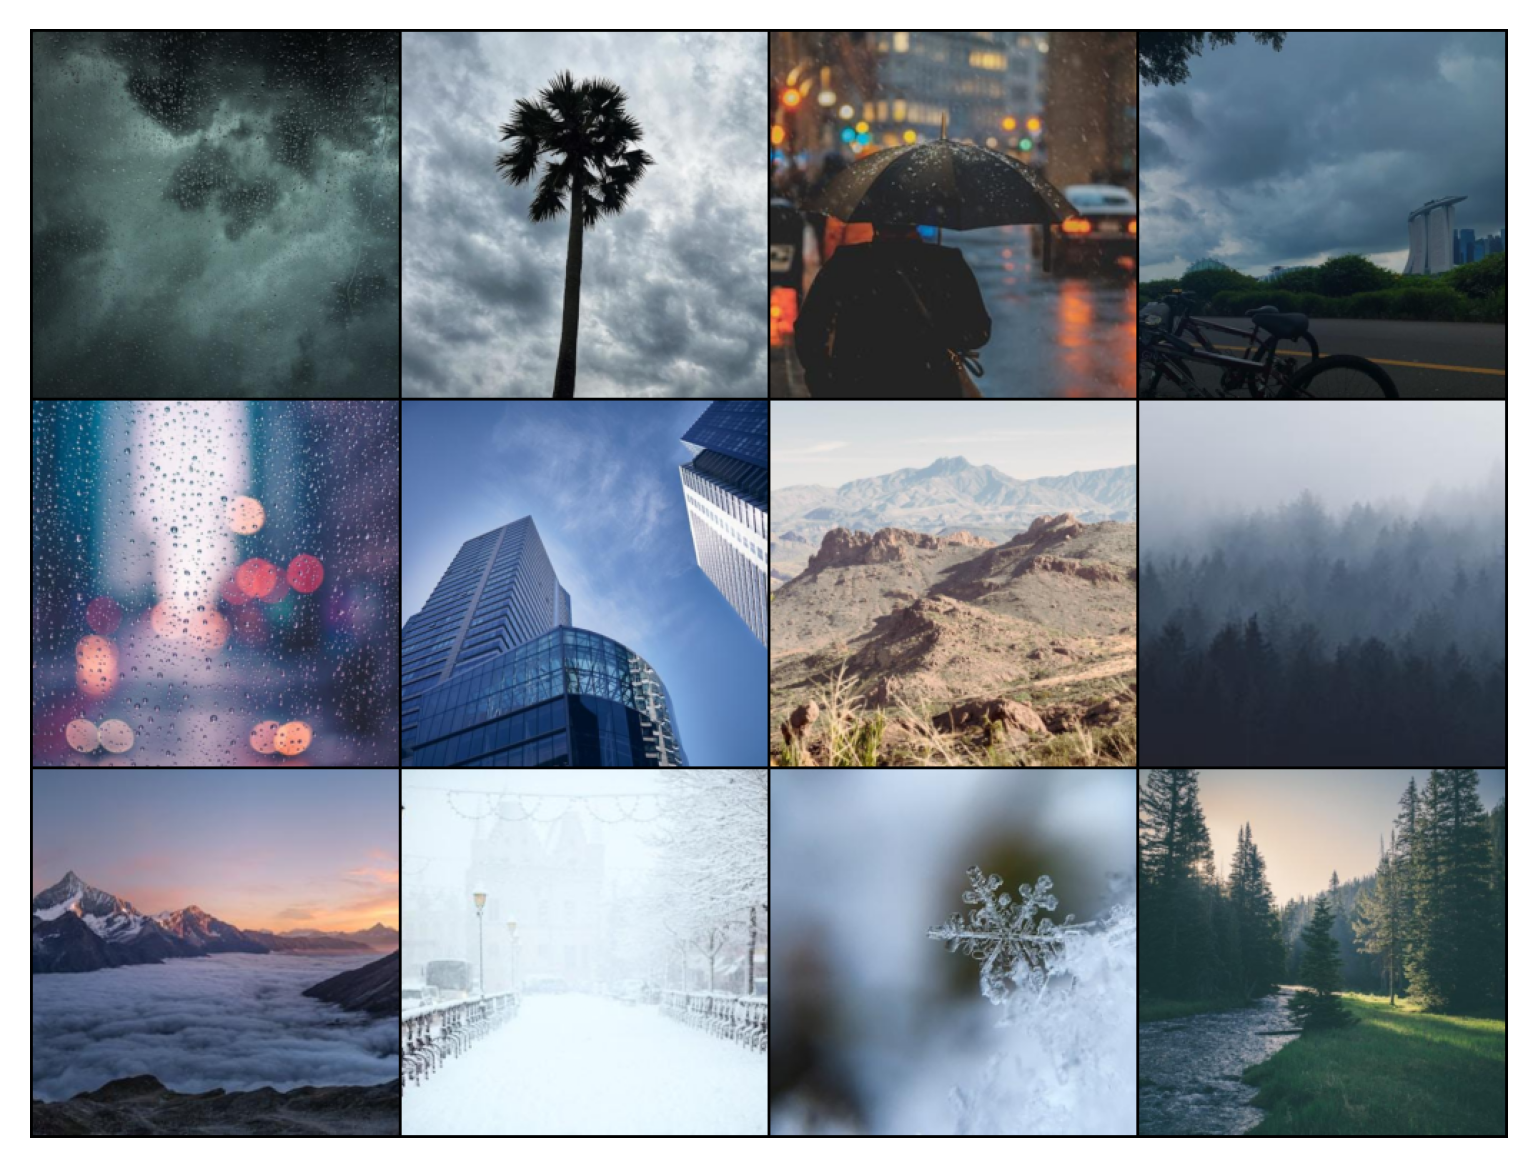

In [2]:
import glob

images = [Image.open(x) for x in glob.glob("weather_images/*")]

display_grid(images, nrow=4)

## Zero-Shot Image Classification with CLIP

In [3]:
# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

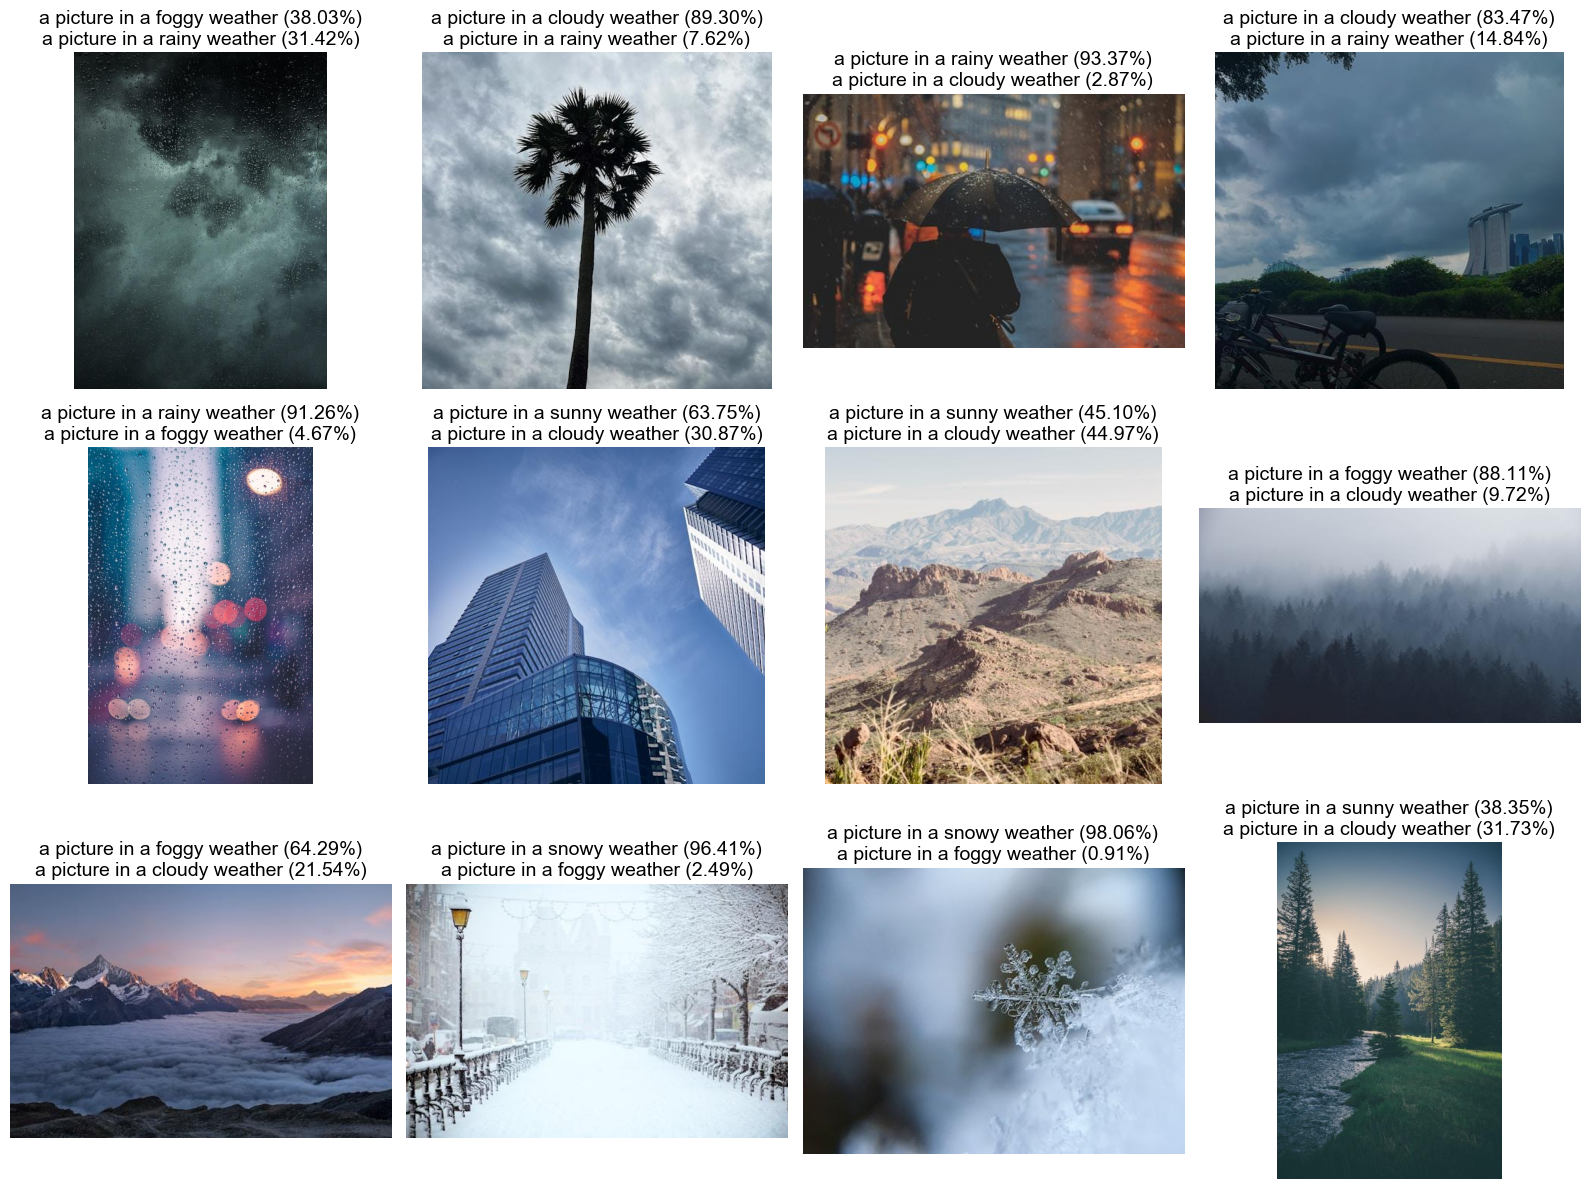

In [11]:
# Define candidate labels
classes = [
    "a picture in a cloudy weather", 
    "a picture in a sunny weather", 
    "a picture in a foggy weather", 
    "a picture in a rainy weather", 
    "a picture in a snowy weather"
]

# Process inputs
inputs = clip_processor(
    text=classes, 
    images=images, 
    return_tensors="pt", 
    padding=True
)

# Get predictions
with torch.no_grad():
    # Run through the model
    outputs = clip_model(**inputs)

    # Get the logits (classification scores for our classes)
    logits_per_image = outputs.logits_per_image

    # Apply softmax to get probabilities
    probs = logits_per_image.softmax(dim=1)

display_clip_results(images, probs, classes)

## Florence-2 Tasks

Let's instance Florence 2:

In [5]:
import torch
from PIL import Image
from transformers import pipeline

pipeline = pipeline(
    "image-text-to-text",
    device=0,
    dtype=torch.bfloat16,
    model="ducviet00/Florence-2-base-hf"
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use mps:0


These are the things that Florence can do:
* `<OCR>`
* `<OCR_WITH_REGION>`
* `<CAPTION>`
* `<DETAILED_CAPTION>`
* `<MORE_DETAILED_CAPTION>`
* `<OD>`
* `<DENSE_REGION_CAPTION>`
* `<CAPTION_TO_PHRASE_GROUNDING>`
* `<REFERRING_EXPRESSION_SEGMENTATION>`
* `<REGION_TO_SEGMENTATION>`
* `<OPEN_VOCABULARY_DETECTION>`
* `<REGION_TO_CATEGORY>`
* `<REGION_TO_DESCRIPTION>`
* `<REGION_TO_OCR>`
* `<REGION_PROPOSAL>`

Refer to the docs for details on each one of these.

### 2.1 Image Captioning

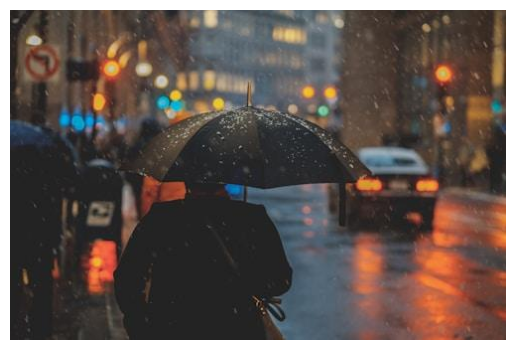

In [6]:
_ = plt.imshow(images[2])
_ = plt.axis("off")

In [7]:
# Image captioning
task = "<CAPTION>"
parsed_answer = pipeline(images[2], task)
print(parsed_answer[0]['generated_text'])

<CAPTION>a person walking in the rain with an umbrella


In [9]:
import textwrap

task = "<MORE_DETAILED_CAPTION>"
parsed_answer = pipeline(images[2], task)

# Print wrapping at 100 characters
print(
    textwrap.fill(
        parsed_answer[0]['generated_text'], 
        width=100
    )
)

<MORE_DETAILED_CAPTION>The image shows a person walking on a busy street in the rain. The person is
holding a black umbrella and is walking towards the right side of the image. The street is wet and
there are cars and traffic lights visible in the background. The sky is dark and it appears to be
raining heavily. The image is taken from a low angle, looking down on the person and the street.


### 2.3 OCR

Florence 2 can also do Optical Character Recognition in images:

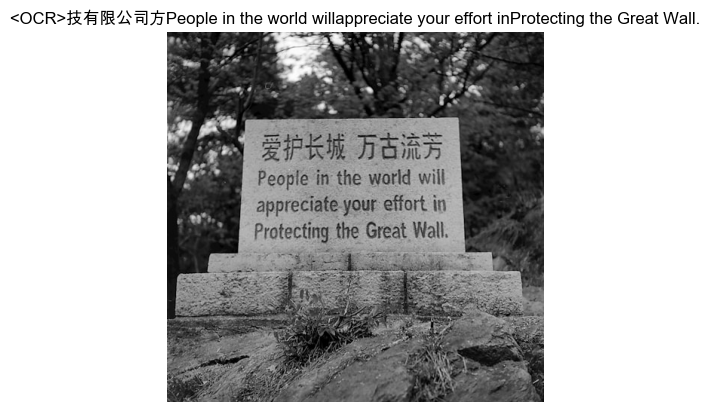

In [10]:
# Since the image contains some non-English text, we set a font that supports it
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']

ocr_sample = Image.open("ocr_sample.jpg")

task = "<OCR>"
parsed_answer = pipeline(ocr_sample, task)

# Display image and answer
fig, sub = plt.subplots()
sub.imshow(ocr_sample)
sub.axis("off")
_ = sub.set_title(parsed_answer[0]['generated_text'])